# Download the single-cell-level profiles for A549

In [1]:
import os
from pathlib import Path
import s3fs
from tqdm import tqdm
import pandas as pd
import scanpy as sc
import re
from lamin_utils import logger
import pycytominer
from pycytominer.operations import RobustMAD
import numpy as np
import matplotlib.pyplot as plt
import itertools

from dotenv import load_dotenv
load_dotenv()

_PROJ_DIR = Path(os.getenv("_PROJ_DIR"))
_DATA_DIR = Path(os.getenv("_DATA_DIR"))
_PLATE_DATA_PATH = _DATA_DIR / "A549_guides"
_SC_DATA_PATH = _DATA_DIR / "A549_singlecell"
_RESULTS_DIR = _PROJ_DIR / "results"

def _get_plate_id_from_path(path: Path) -> str:
    pat = re.compile(r"___(?P<plate_id>CP\d{3}[A-Z])___")
    m = pat.search(str(path))
    plate_id = m["plate_id"] if m else None
    if not plate_id:
        raise ValueError("Couldn't find plate ID.")
    return plate_id

## Get raw files from bucket

In [7]:
bucket_prefix = "cellpainting-gallery/cpg0021-periscope/broad/workspace/profiles/A549/single_cell"
pattern = "20200805_A549_WG_Screen_single_cell_profiles_ALLBATCHES___*___ALLWELLS.csv.gz"

_SC_DATA_PATH.mkdir(parents=True, exist_ok=True)

fs = s3fs.S3FileSystem(anon=True)  # unsigned/public
paths = fs.glob(f"{bucket_prefix}/{pattern}")  # server-side glob


for src in tqdm(paths[:1], desc="Downloading"):
    out = _SC_DATA_PATH / Path(src).name
    if out.exists():
        # skip if already downloaded the full file
        info = fs.info(src)
        if out.stat().st_size == info.get("Size", -1):
            continue
    fs.get(src, str(out))


Downloading: 100%|██████████| 1/1 [06:22<00:00, 382.58s/it]


In [9]:
for path in _SC_DATA_PATH.rglob("*.csv.gz"):

    data = pd.read_csv(path)

In [12]:
data.to_parquet(str(path).replace(".csv.gz", ".parquet"))

In [ ]:
data[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]] = data["Metadata_Foci_site"].str.split("-", expand=True)

metadata_cols = data.filter(like="Metadata").columns.tolist()

/localscratch/tim.treis/ipykernel_773668/3297743101.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]] = data["Metadata_Foci_site"].str.split("-", expand=True)
/localscratch/tim.treis/ipykernel_773668/3297743101.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]] = data["Metadata_Foci_site"].str.split("-", expand=True)
/localscratch/tim.treis/ipykernel_773668/3297743101.py:1: PerformanceWarning: DataFrame is hig

In [32]:
data_subset = data[data.Metadata_Well.isin(["Well1", "Well2", "Well3"])]

In [34]:
# Median-aggregate into guides, stratified by well

keys = ["Metadata_Well", "Metadata_Foci_Barcode_MatchedTo_Barcode"]

num_cols = data_subset.select_dtypes(include="number").columns.difference(keys, sort=False)
str_cols = data_subset.select_dtypes(exclude="number").columns.difference(keys, sort=False)

agg_map = {**{c: "median" for c in num_cols}, **{c: "first" for c in str_cols}}

data_subset_agg = (
    data_subset
    .groupby(keys, sort=False, observed=True)
    .agg(agg_map)
    .reset_index()
)

/localscratch/tim.treis/ipykernel_773668/496795274.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .reset_index()
/localscratch/tim.treis/ipykernel_773668/496795274.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .reset_index()


In [ ]:
data_subset_agg_scaled = pycytominer.normalize(
    profiles=data_subset_agg,
    features="infer",
    meta_features="infer",
    samples="Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting'",
)

/ictstr01/groups/ml01/workspace/ttreis/projects/PERISCOPE_sanity_check/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/ictstr01/groups/ml01/workspace/ttreis/projects/PERISCOPE_sanity_check/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/ictstr01/groups/ml01/workspace/ttreis/projects/PERISCOPE_sanity_check/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [38]:
feature_select_opts = [
    "variance_threshold",
    "drop_na_columns",
    "correlation_threshold",
    "blocklist",
    "drop_outliers",
]

data_subset_agg_filtered = pycytominer.feature_select(
    profiles=data_subset_agg_scaled,
    features="infer",
    samples="Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting'",
    operation=feature_select_opts,
)

In [40]:
logger.info(f"Shape before dropping NaN-columns: {data_subset_agg_filtered.shape}")
cols_with_nans = data_subset_agg_filtered.isna().sum(axis=0)
cols_with_nans = cols_with_nans[cols_with_nans > 0]
data_subset_agg_filtered = data_subset_agg_filtered.drop(columns=cols_with_nans.index.tolist())
logger.info(f"Shape after dropping NaN-columns: {data_subset_agg_filtered.shape}")

• Shape before dropping NaN-columns: (153321, 1617)


• Shape after dropping NaN-columns: (153321, 1582)


datetime.datetime(2025, 11, 13, 14, 9, 5, 382453, tzinfo=datetime.timezone.utc)

In [41]:
adata_filtered = sc.AnnData(
    X=data_subset_agg_filtered.drop(columns=metadata_cols),
    obs=data_subset_agg.filter(like="Metadata"),
)
adata_filtered

/ictstr01/groups/ml01/workspace/ttreis/projects/PERISCOPE_sanity_check/.pixi/envs/default/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 153321 × 1548
    obs: 'Metadata_Well', 'Metadata_Foci_Barcode_MatchedTo_Barcode', 'Metadata_Foci_Parent_Cells', 'Metadata_Foci_Cell_Quality_Index', 'Metadata_Foci_Barcode_MatchedTo_Score_mean', 'Metadata_Foci_Barcode_MatchedTo_Score_count', 'Metadata_Foci_ImageNumber', 'Metadata_Foci_site_location', 'Metadata_Cells_ImageNumber_x', 'Metadata_Cells_ObjectNumber', 'Metadata_Cells_Parent_Nuclei_x', 'Metadata_Cytoplasm_ImageNumber_x', 'Metadata_Cytoplasm_ObjectNumber_x', 'Metadata_Cytoplasm_Parent_Cells_x', 'Metadata_Cytoplasm_Parent_Nuclei_x', 'Metadata_Nuclei_ImageNumber_x', 'Metadata_Nuclei_ObjectNumber_x', 'Metadata_Cells_ImageNumber_y', 'Metadata_Cells_Parent_Nuclei_y', 'Metadata_Cytoplasm_ImageNumber_y', 'Metadata_Cytoplasm_ObjectNumber_y', 'Metadata_Cytoplasm_Parent_Cells_y', 'Metadata_Cytoplasm_Parent_Nuclei_y', 'Metadata_Nuclei_ImageNumber_y', 'Metadata_Nuclei_ObjectNumber_y', 'Metadata_Foci_Barcode_MatchedTo_GeneCode', 'Metadata_Foci_cell_qual

In [42]:
sc.pp.pca(adata_filtered)
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)

/ictstr01/groups/ml01/workspace/ttreis/projects/PERISCOPE_sanity_check/.pixi/envs/default/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 1548 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)
/ictstr01/groups/ml01/workspace/ttreis/projects/PERISCOPE_sanity_check/.pixi/envs/default/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


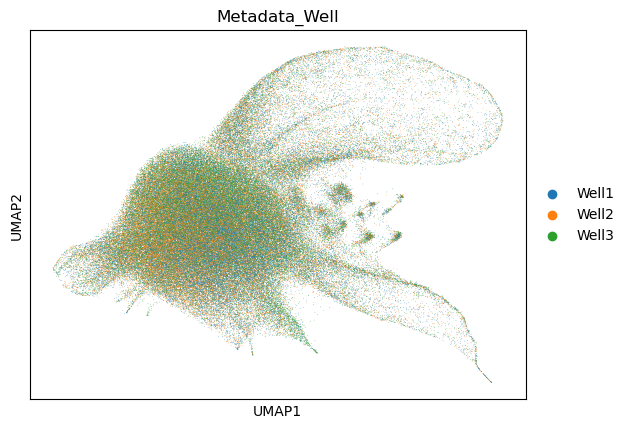

In [44]:
sc.pl.umap(adata_filtered, color="Metadata_Well")

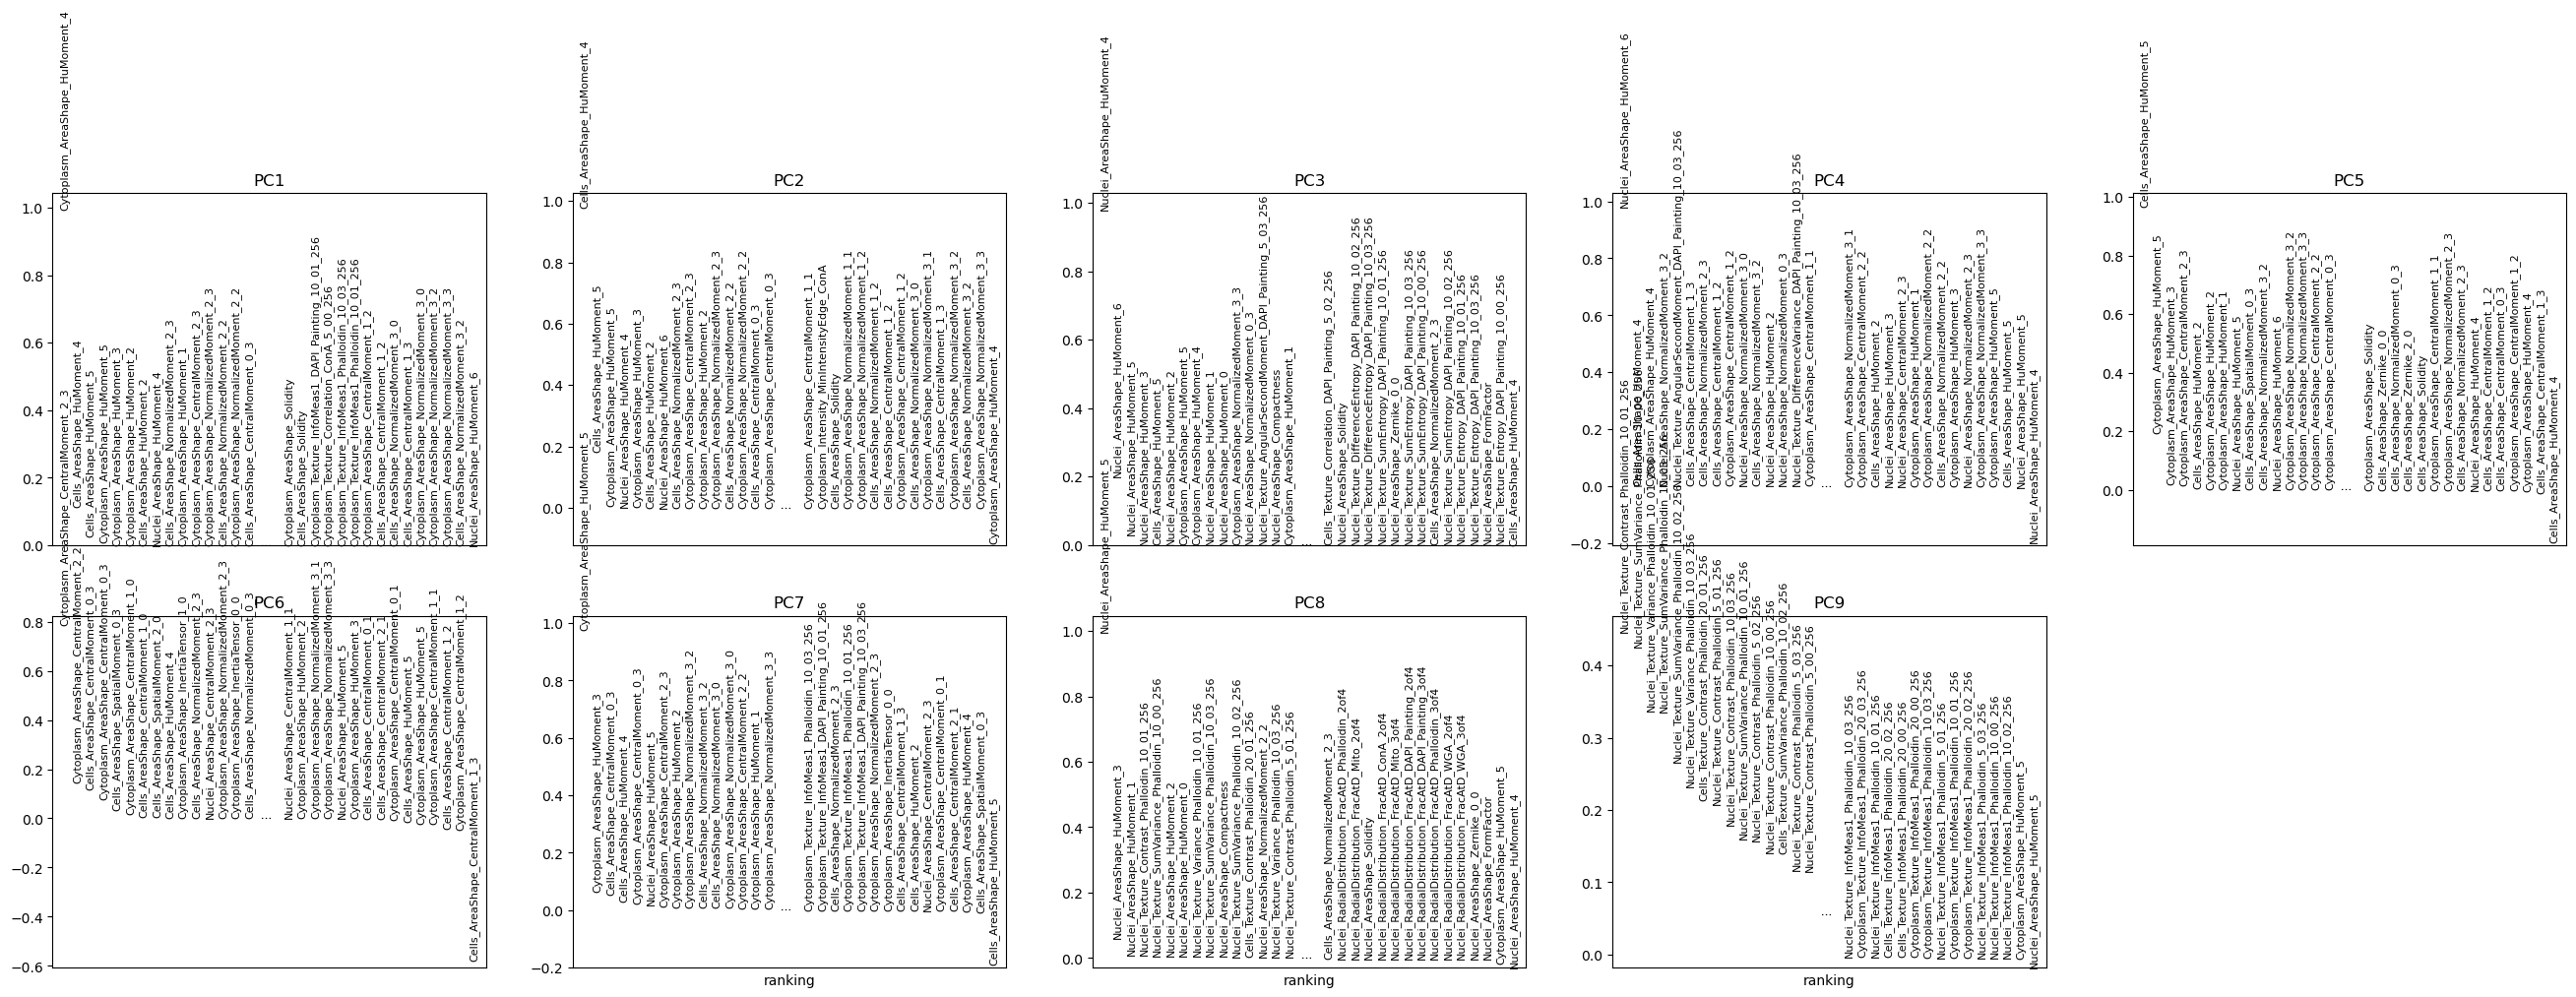

In [ ]:
sc.pl.pca_loadings(adata_filtered, components=list(range(1, 11, 1)))

In [52]:
# Let's remove HuMoments

humoment_cols = data_subset_agg_filtered.filter(like="HuMoment").columns.tolist()

adata_filtered = sc.AnnData(
    X=data_subset_agg_filtered.drop(columns=metadata_cols + humoment_cols),
    obs=data_subset_agg.filter(like="Metadata"),
)
adata_filtered

/ictstr01/groups/ml01/workspace/ttreis/projects/PERISCOPE_sanity_check/.pixi/envs/default/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 153321 × 1531
    obs: 'Metadata_Well', 'Metadata_Foci_Barcode_MatchedTo_Barcode', 'Metadata_Foci_Parent_Cells', 'Metadata_Foci_Cell_Quality_Index', 'Metadata_Foci_Barcode_MatchedTo_Score_mean', 'Metadata_Foci_Barcode_MatchedTo_Score_count', 'Metadata_Foci_ImageNumber', 'Metadata_Foci_site_location', 'Metadata_Cells_ImageNumber_x', 'Metadata_Cells_ObjectNumber', 'Metadata_Cells_Parent_Nuclei_x', 'Metadata_Cytoplasm_ImageNumber_x', 'Metadata_Cytoplasm_ObjectNumber_x', 'Metadata_Cytoplasm_Parent_Cells_x', 'Metadata_Cytoplasm_Parent_Nuclei_x', 'Metadata_Nuclei_ImageNumber_x', 'Metadata_Nuclei_ObjectNumber_x', 'Metadata_Cells_ImageNumber_y', 'Metadata_Cells_Parent_Nuclei_y', 'Metadata_Cytoplasm_ImageNumber_y', 'Metadata_Cytoplasm_ObjectNumber_y', 'Metadata_Cytoplasm_Parent_Cells_y', 'Metadata_Cytoplasm_Parent_Nuclei_y', 'Metadata_Nuclei_ImageNumber_y', 'Metadata_Nuclei_ObjectNumber_y', 'Metadata_Foci_Barcode_MatchedTo_GeneCode', 'Metadata_Foci_cell_qual

In [53]:
sc.pp.pca(adata_filtered)
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)

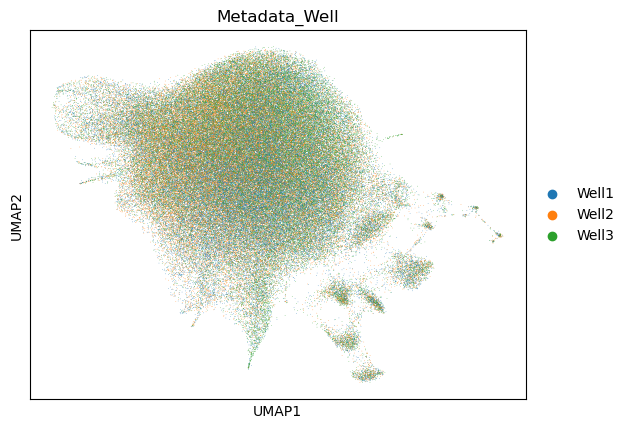

In [54]:
sc.pl.umap(adata_filtered, color="Metadata_Well")

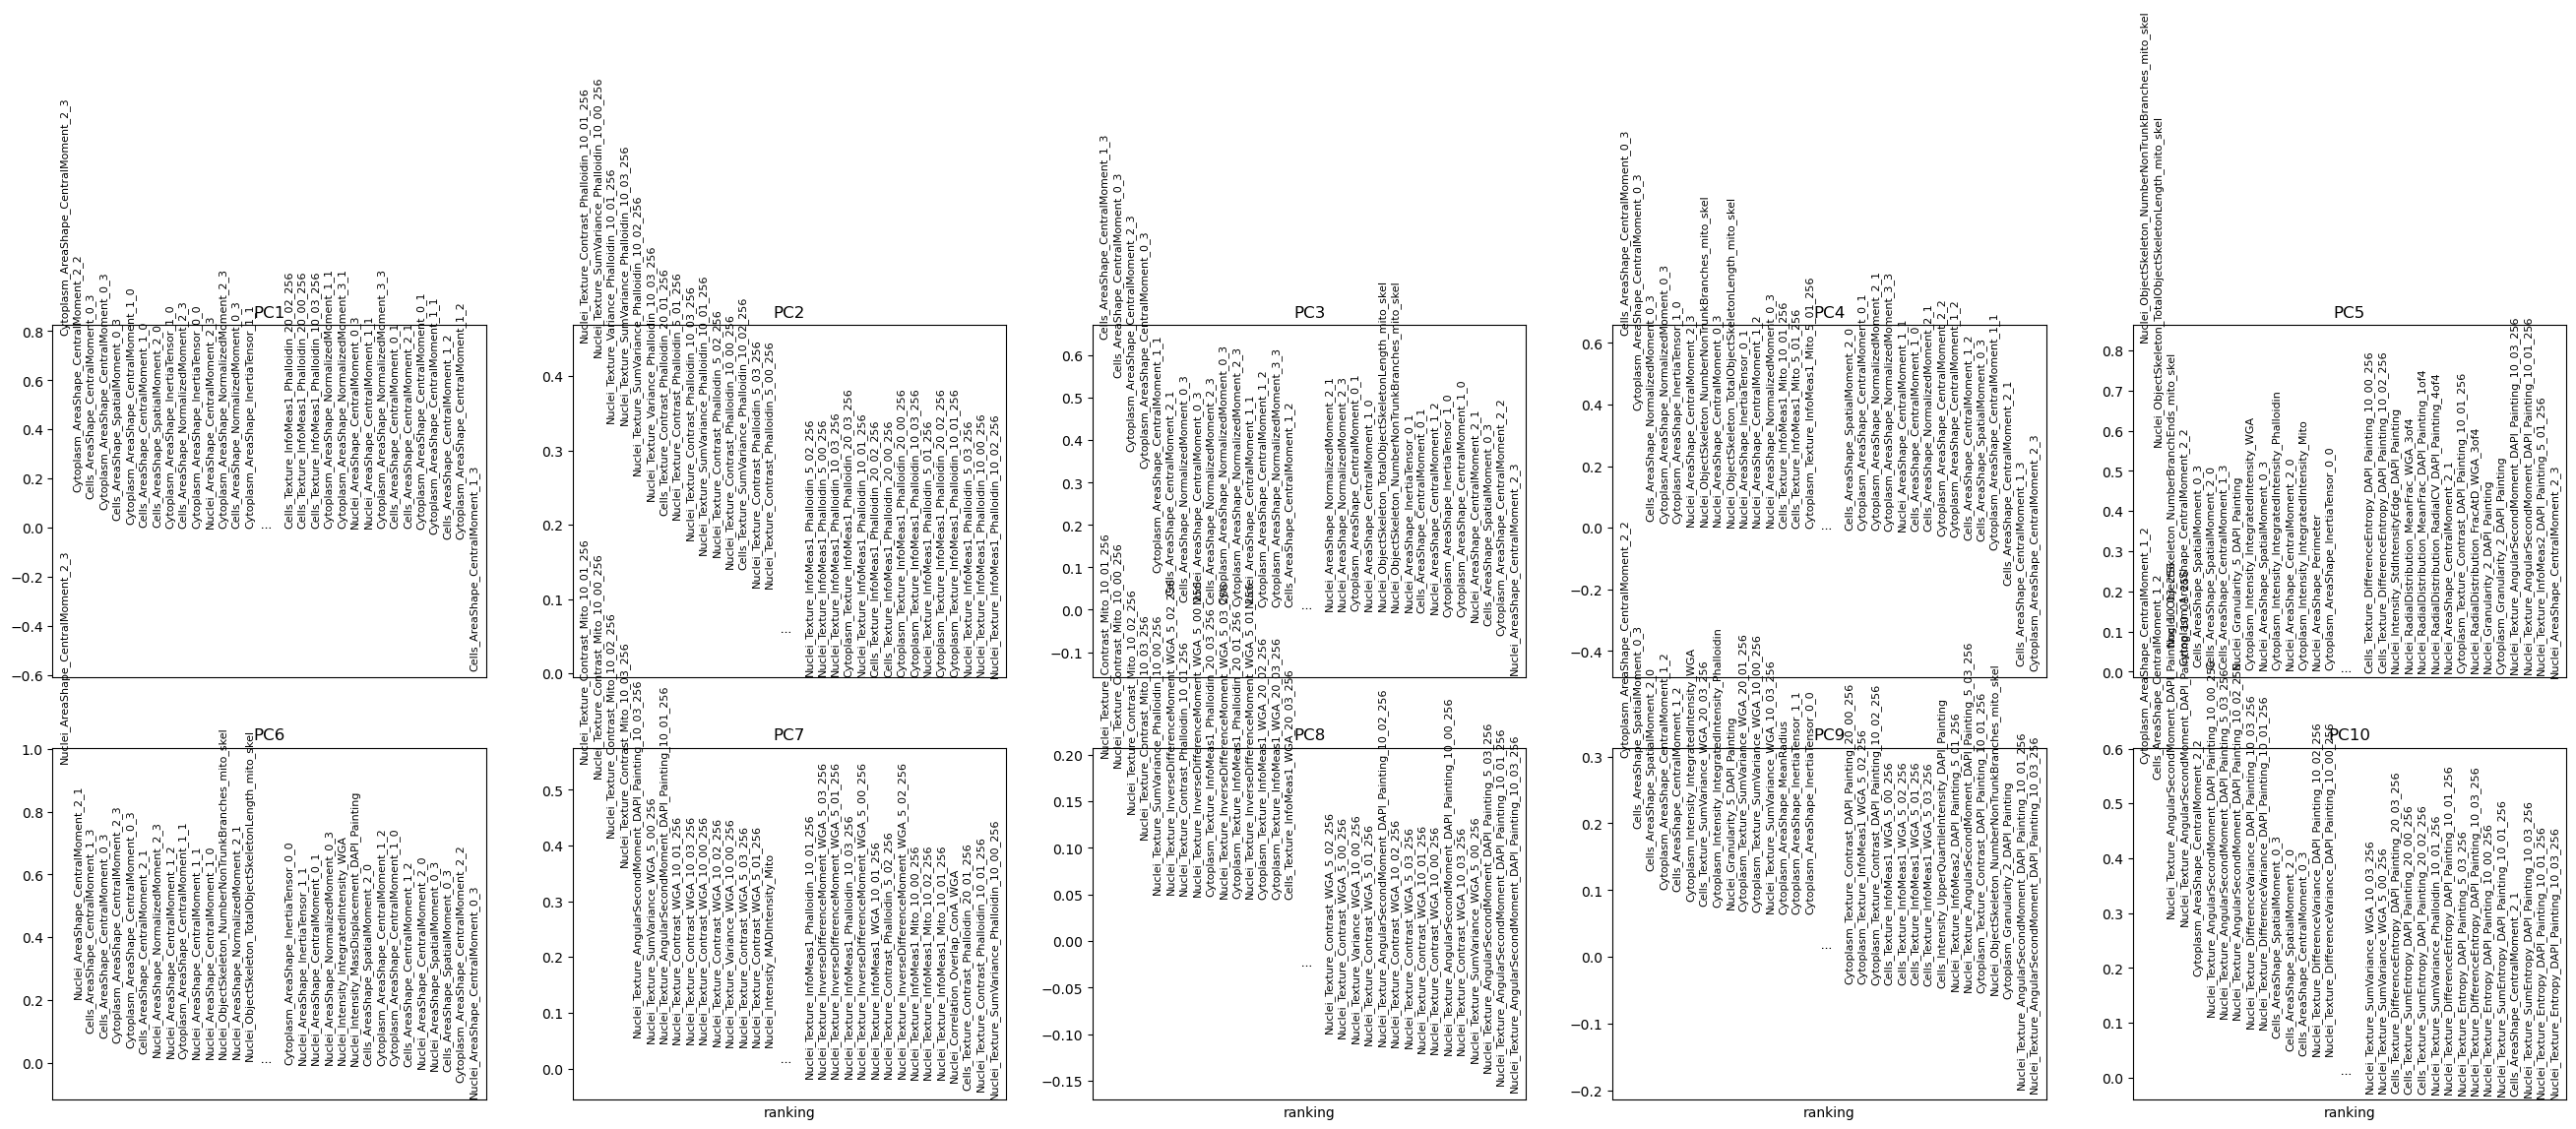

In [55]:
sc.pl.pca_loadings(adata_filtered, components=list(range(1, 11, 1)))

In [61]:
adata_filtered.obs.Metadata_Foci_Barcode_MatchedTo_GeneCode[adata_filtered.obs.Metadata_Foci_Barcode_MatchedTo_GeneCode.str.contains("ATP")]

73           ATP4A
749          ATP4B
939        ATP13A3
946       ATP6V1C1
1059       ATP6AP2
            ...   
152688      ATPAF1
152772      ATP8A2
152839      ATP11A
153149      ATP10D
153265      ATP12A
Name: Metadata_Foci_Barcode_MatchedTo_GeneCode, Length: 664, dtype: category
Categories (20373, object): ['A1BG', 'A1CF', 'A2M', 'A2ML1', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'nontargeting']

In [75]:
genes_from_paper = ["TOMM20", "TMEM251", "GNPTAB", "GNPTG"]

adata_filtered.obs["example_genes"] = [g if g in genes_from_paper else np.nan for g in adata_filtered.obs.Metadata_Foci_Barcode_MatchedTo_GeneCode]

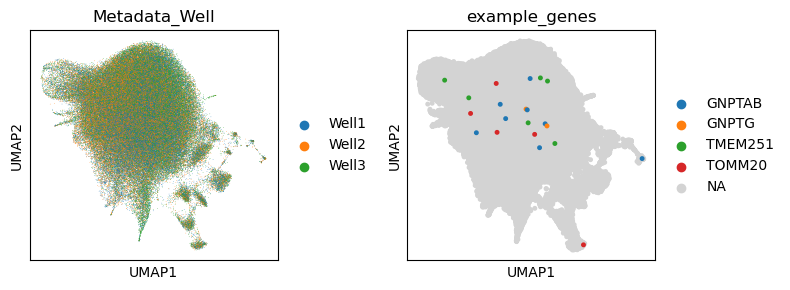

In [78]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))

sc.pl.umap(adata_filtered, color="Metadata_Well", ax=axs[0], show=False)
sc.pl.umap(adata_filtered, color="example_genes", size=50, ax=axs[1], show=False)

fig.tight_layout()